# Project 2: Recommender System

In [1]:
#Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn import mixture
from notebook_helpers import *
from scipy import sparse
from plots import *
import scipy.sparse as sp
%load_ext autoreload
%autoreload 2

## 1-Preprocessing

In [2]:
#Loading the training data
data=pd.read_csv('../data/data_train.csv')
data.head()

,Id,Prediction
0,r44_c1,4
1,r61_c1,3
2,r67_c1,4
3,r72_c1,3
4,r86_c1,5


In [3]:
#Extracting row and column numbers
data['Id']=data['Id'].apply(lambda x: re.findall(r'\d+', str(x)))
data.head()

,Id,Prediction
0,"[44, 1]",4
1,"[61, 1]",3
2,"[67, 1]",4
3,"[72, 1]",3
4,"[86, 1]",5


In [4]:
#Row and column values to features
num_id_data=data
num_id_data[['Row', 'Col']]=pd.DataFrame(data.Id.values.tolist(), index= data.index)
num_id_data=num_id_data.drop(columns='Id')
num_id_data.head()

,Prediction,Row,Col
0,4,44,1
1,3,61,1
2,4,67,1
3,3,72,1
4,5,86,1


In [5]:
cli_vs_mov=num_id_data.pivot(index='Row', columns='Col', values='Prediction')
cli_vs_mov.head()

Col,1,10,100,1000,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
Row,,,,,,,,,,,,,,,,,,,,,
1,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN
100,NaN,5.0,NaN,NaN,5.0,NaN,3.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1000,NaN,2.0,4.0,2.0,5.0,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,4.0,2.0,NaN,5.0,1.0,NaN,2.0,3.0
10000,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,2.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN


## 2-Helper Functions

In [19]:
def initialize_clusters(data, k):
    """initialize the k cluster centers (the means).
    input:
        data: original data with shape (num_sample, num_feature).
        k: predefined number of clusters for the k-means algorithm.
    output:
        a numpy array with shape (k, num_feature)
    """
    # ***************************************************************************************************
    # INSERT YOUR CODE HERE
    # TODO: initialize cluster centers.
    # TODO: Make sure you choose k clusters from the data itself,
    #       or ensure otherwise that your initializations have the same scaling as the data
    # ***************************************************************************************************
    np.random.seed(1)
    
    min_data=np.nanmin(data,axis=0)
    max_data=np.nanmax(data,axis=0)
    return np.random.uniform(min_data,max_data,(k,data.shape[1]))

In [7]:
def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: build distance matrix
    # ***************************************************
    return np.array([np.nansum((data-mu[i])**2,axis=1) for i in range(len(mu))]).T

In [8]:
def update_kmeans_parameters(data, mu_old):
    """update the parameter of kmeans
    return:
        losses: loss of each data point with shape (num_samples, 1)
        assignments: assignments vector z with shape (num_samples, 1)
        mu: mean vector mu with shape (k, num_features)
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: update kmeans parameters
    # ***************************************************
    d=build_distance_matrix(data, mu_old)
    losses=np.min(d,1)
    assignments=np.argmin(d,1)
    mu=np.array([np.mean(data[assignments==i],0) for i in range(mu_old.shape[0])])
    mu=np.where(np.isnan(mu),mu_old,mu)
    return losses,assignments,mu

In [9]:
def kmeans(data, k, max_iters, threshold):
    """run the k-means algorithm."""
    output_figure = "kmeans_figures/"
    #Initialize the cluster.
    mu_old = initialize_clusters(data, k)
    average_loss=0
    #Start the kmeans algorithm.
    for iter in range(max_iters):
        #Update z and mu
        losses, assignments, mu = update_kmeans_parameters(data, mu_old)
        #Calculate the average loss over all points
        old_avg_loss=average_loss
        average_loss = np.mean(losses)
        print("The current iteration of k-means is: {i}, \
               the average loss is {l}.".format(i=iter, l=average_loss))
        #Check converge
        if iter > 0 and np.abs(average_loss - old_avg_loss) < threshold:
            break
        #Update k-means information.
        mu_old = mu
    return assignments, mu, average_loss

In [10]:
#Returns the most common value for each column of n
def most_common(x):
    top_freq=[]
    for i in range(x.shape[1]):
        temp=np.unique(x[:,i],return_counts=True)
        top_freq=np.append(top_freq,temp[0][temp[1].argmax()])
    return top_freq

In [11]:
#Splits the data between a train and a test dataset
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    
    train=sp.lil_matrix(valid_ratings.shape)
    test=sp.lil_matrix(valid_ratings.shape)
    x,_=valid_ratings.nonzero()
    x=np.unique(x)
    for j,row in enumerate(x):
        if j%10000==0:
            print(j/len(x))
        _,y=valid_ratings[row].nonzero()
        perm_indices=np.random.permutation(range(len(y)))
        y_shuffled=y[perm_indices]
        bound=int(p_test*y_shuffled.shape[0])
        for i,col in enumerate(y_shuffled):
            if i<=bound:
                test[row,col]=valid_ratings[row,col]
            else:
                train[row,col]=valid_ratings[row,col]
        
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

## 3-Cluster Aggregation Approaches

In [12]:
#Generating a prediction using the clusters of similar users
#PS:Yields the best results
def cluster_agg(assignments, mu, k, train):
    #Rounding the cluster values to get valid ratings
    mu_rounded=np.round(mu)
    #Computing the resulting rating matrix
    prediction=train.copy()
    for j in range(k):
        prediction[assignments==j]=np.where(np.isnan(prediction[assignments==j]),mu_rounded[j],prediction[assignments==j])   
    return prediction

In [13]:
#Generating a prediction using the median of the scores of similar users
def median_agg(assignments, mu, k, train):
    #Computing the resulting rating matrix
    prediction=train.copy().to_numpy()
    #Computing the general median per column
    median=np.median(prediction,0)[np.newaxis,:]
    for j in range(k):
        #Computing the medians of cluster j
        medians_j=np.rint(np.nanmedian(np.concatenate((prediction[assignments==j],median),0),0))
        #Assigning the median to the unkown ratings
        prediction[assignments==j]=np.where(np.isnan(prediction[assignments==j]),medians_j,prediction[assignments==j])
    return prediction

In [14]:
#Generating a prediction using the most frequent score among similar users
def mode_agg(assignments, mu, k, train):
    #Computing the resulting rating matrix
    prediction=train.copy().to_numpy()
    #Computing the general mode per column
    mode=most_common(prediction)
    for j in range(k):
        #Computing the modes of cluster j
        modes_j=most_common(prediction[assignments==j])
        modes_j=np.where(np.isnan(modes_j),mode,modes_j)
        #Assigning the median to the unkown ratings
        prediction[assignments==j]=np.where(np.isnan(prediction[assignments==j]),modes_j,prediction[assignments==j])
    return prediction

## 4-Parameter Selection

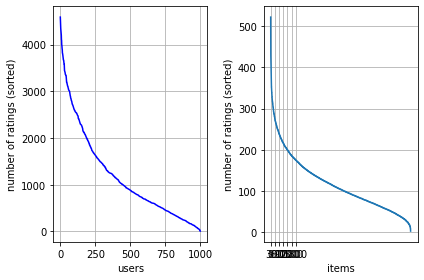

0.0
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1053792
Total number of nonzero elements in test data:123160


In [20]:
#Modifying the data for compatibility reasons
ratings=cli_vs_mov.copy()
ratings[np.isnan(ratings)]=0
ratings=sparse.csr_matrix(ratings)
#Splitting the data between a train and a test dataset
num_items_per_user, num_users_per_item = plot_raw_data(ratings)
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)
#Modifying the train and test data for compatibility reasons
train=pd.DataFrame(train.todense())
train[train==0]=np.nan
test_size=test.count_nonzero()
test=np.asarray(test.todense())
test[test==0]=np.nan

For k= 1 :
The current iteration of k-means is: 0,                the average loss is 343.8489388763263.
The current iteration of k-means is: 1,                the average loss is 111.70627300168742.
The current iteration of k-means is: 2,                the average loss is 111.70627300168742.
For k= 2 :
The current iteration of k-means is: 0,                the average loss is 319.8230712382255.
The current iteration of k-means is: 1,                the average loss is 110.37021952112333.
The current iteration of k-means is: 2,                the average loss is 107.40066029760014.
The current iteration of k-means is: 3,                the average loss is 106.48430026986571.
The current iteration of k-means is: 4,                the average loss is 106.36146851454907.
The current iteration of k-means is: 5,                the average loss is 106.33994309062902.
The current iteration of k-means is: 6,                the average loss is 106.33427327895966.
The current iteration of k-mea

The current iteration of k-means is: 37,                the average loss is 103.28038017231523.
The current iteration of k-means is: 38,                the average loss is 103.28031867717253.
The current iteration of k-means is: 39,                the average loss is 103.28024622513834.
The current iteration of k-means is: 40,                the average loss is 103.28023755040061.
The current iteration of k-means is: 41,                the average loss is 103.28021414234948.
The current iteration of k-means is: 42,                the average loss is 103.28013260915063.
The current iteration of k-means is: 43,                the average loss is 103.28006672843553.
The current iteration of k-means is: 44,                the average loss is 103.28003013668658.
The current iteration of k-means is: 45,                the average loss is 103.28003013668658.
For k= 5 :
The current iteration of k-means is: 0,                the average loss is 312.427423495603.
The current iteration of k-means

The current iteration of k-means is: 18,                the average loss is 101.08675258101249.
The current iteration of k-means is: 19,                the average loss is 101.08242513463462.
The current iteration of k-means is: 20,                the average loss is 101.08061527403703.
The current iteration of k-means is: 21,                the average loss is 101.07906814369272.
The current iteration of k-means is: 22,                the average loss is 101.07662492071911.
The current iteration of k-means is: 23,                the average loss is 101.07526444558913.
The current iteration of k-means is: 24,                the average loss is 101.07340047977884.
The current iteration of k-means is: 25,                the average loss is 101.0723508695778.
The current iteration of k-means is: 26,                the average loss is 101.06935193975661.
The current iteration of k-means is: 27,                the average loss is 101.06832184622544.
The current iteration of k-means is: 28, 

The current iteration of k-means is: 36,                the average loss is 100.16848946933406.
The current iteration of k-means is: 37,                the average loss is 100.16836169874033.
The current iteration of k-means is: 38,                the average loss is 100.16836169874033.
For k= 10 :
The current iteration of k-means is: 0,                the average loss is 301.2314604048557.
The current iteration of k-means is: 1,                the average loss is 106.77665898344635.
The current iteration of k-means is: 2,                the average loss is 102.90869464811163.
The current iteration of k-means is: 3,                the average loss is 101.75986909884884.
The current iteration of k-means is: 4,                the average loss is 101.12547197938632.
The current iteration of k-means is: 5,                the average loss is 100.66859855317973.
The current iteration of k-means is: 6,                the average loss is 100.39081811546919.
The current iteration of k-means is:

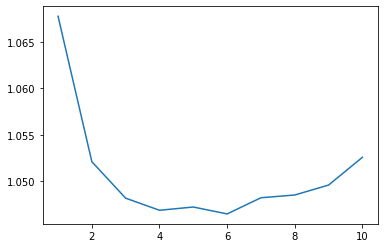

In [21]:
#Defining the aggregation method
agg=cluster_agg
#Max number of clusters
k = 10
max_iters = 100
threshold = 1e-12
#Initializing the array of test losses
losses=[]
#Grid-searching the number of clusters by cross-validation
for i in range(1,k+1):
    print('For k=',i,':')
    #Training the model
    assignments, mu, _=kmeans(train, i, max_iters, threshold)
    #Computing the test RMSE
    loss=np.nanmean((test-agg(assignments, mu, i, train.to_numpy()))**2)**(1/2)
    #Adding the test RMSE to the array of losses
    losses.append(loss)
#Plotting 'RMSE vs k'
plt.plot(range(1,k+1),losses)
#Getting the best loss and k
k_opt=np.argmin(losses)+1
min_loss=np.min(losses)
print('The best loss is:',min_loss,' and the best k is:',k_opt)

In [317]:
#Defining the remaining model parameters
max_iters = 100
threshold = 1
#Building the model on the full dataset
assignments, mu, _=kmeans(cli_vs_mov, k_opt, max_iters, threshold)
#Generation the predictions
classified=cluster_agg(assignments, mu,k_opt,cli_vs_mov)

The current iteration of k-means is: 0,                the average loss is 351.2401170958377.
The current iteration of k-means is: 1,                the average loss is 121.10913726420793.
The current iteration of k-means is: 2,                the average loss is 116.73341462442188.
The current iteration of k-means is: 3,                the average loss is 115.49334925559329.
The current iteration of k-means is: 4,                the average loss is 114.96369887321319.


## 5-Postprocessing

In [319]:
#Converting the columns back to the Col column and making Row a column instead of an index
classified=pd.melt(classified.reset_index(), id_vars=['Row'], var_name='Col', value_name='Rating')
classified.head()

,Row,Col,Rating
0,1,1,3.0
1,10,1,3.0
2,100,1,3.0
3,1000,1,4.0
4,10000,1,4.0


In [320]:
#Converting Row and Col values into an id
classified.index='r'+classified['Row']+'_c'+classified['Col']
classified=classified.drop(columns=['Row','Col'])
classified.head()

,Rating
r1_c1,3.0
r10_c1,3.0
r100_c1,3.0
r1000_c1,4.0
r10000_c1,4.0


In [321]:
#Loading the sample submission data
sample_sumbission=pd.read_csv('../data/sampleSubmission.csv')
sample_sumbission.head()

,Id,Prediction
0,r37_c1,3
1,r73_c1,3
2,r156_c1,3
3,r160_c1,3
4,r248_c1,3


In [322]:
classified=classified[classified.index.isin(list(sample_sumbission['Id']))].reset_index().rename(columns={'index': 'Id', 'Rating':'Prediction'})
classified.head()

,Id,Prediction
0,r1000_c1,4.0
1,r1141_c1,4.0
2,r1146_c1,4.0
3,r1157_c1,3.0
4,r1184_c1,4.0


In [323]:
#Exporting the predictions
classified.to_csv('submission.csv')